# 08 - Spatial Analysis – Subway to Taxi Zone Mapping

This notebook performs spatial joins to associate each **Manhattan subway station** with its corresponding **NYC Taxi Zone**.

### Objectives:
- Extract unique subway station locations from the integrated dataset
- Join subway coordinates with Manhattan taxi zones using:
  - `within` (primary)
  - `nearest` (fallback)
- Produce a clean mapping: `station_complex_id` → `PULocationID`
- Visualize the results spatially

---

**Output:**
- `station_to_zone_mapping.csv`: final station-to-taxi zone mapping


In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
from pathlib import Path
import matplotlib.pyplot as plt

# Set up directory paths (project-root relative for notebooks)
PROJECT_DIR = Path.cwd().parents[0]  # use cwd() instead of __file__ for notebooks
DATA_DIR = PROJECT_DIR / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
MODELING_DIR = PROCESSED_DIR / "modeling"

# File paths
input_parquet = MODELING_DIR / "subway_ridership_modeling_features.parquet"
stations_file = PROCESSED_DIR / "subway_stations.csv"
zones_file = RAW_DIR / "manhattan_taxi_zones.csv"
output_file = PROCESSED_DIR / "station_to_zone_mapping.csv"

# Confirm paths
print("Input file:", input_parquet)
print("Zones file:", zones_file)
print("Output CSV:", output_file)

Input file: c:\Users\neasa\manhattan-subway\data\processed\modeling\subway_ridership_modeling_features.parquet
Zones file: c:\Users\neasa\manhattan-subway\data\raw\manhattan_taxi_zones.csv
Output CSV: c:\Users\neasa\manhattan-subway\data\processed\station_to_zone_mapping.csv


### Step 1: Extract Unique Subway Station Coordinates

We extract a deduplicated list of subway stations with their spatial attributes from the integrated dataset. This list includes `station_complex_id`, `latitude`, `longitude`, and `is_cbd` (if available). It will be used as input for spatial joins with taxi zones.

In [2]:
# Extract unique station metadata
df = pd.read_parquet(input_parquet)

# Include is_cbd if present
expected_cols = ["station_complex_id", "latitude", "longitude", "is_cbd"]
available_cols = [col for col in expected_cols if col in df.columns]

stations_df = (
    df[available_cols]
    .drop_duplicates()
    .sort_values("station_complex_id")
)

# Save to CSV
stations_df.to_csv(stations_file, index=False)

print(f"Saved: {stations_file.name} — {stations_df.shape[0]} unique stations")


Saved: subway_stations.csv — 121 unique stations


### Step 2: Load and Prepare Taxi Zone Geometry

We load NYC taxi zones in WKT format and convert them to a GeoDataFrame for spatial operations.


In [3]:
# Load taxi zone polygons from WKT
zones_df = pd.read_csv(zones_file)

# Keep only valid POLYGON entries
zones_df = zones_df.loc[
    zones_df["geometry"].notnull() & zones_df["geometry"].str.startswith("POLYGON")
].copy()

# Convert WKT to Shapely geometries
zones_df["geometry"] = zones_df["geometry"].apply(wkt.loads)

# Convert to GeoDataFrame
zones_gdf = gpd.GeoDataFrame(zones_df, geometry="geometry", crs="EPSG:4326")

### Step 3: Spatial Join (within + nearest fallback)

We use two strategies to assign stations to zones:
- `within` spatial join as the primary method
- `nearest` join (in projected CRS) for any unmatched stations


In [4]:
# Load station metadata and create GeoDataFrame
stations_df = pd.read_csv(stations_file)
stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df["longitude"], stations_df["latitude"]),
    crs="EPSG:4326"
)

# 1. Spatial join using 'within' predicate
joined_within = gpd.sjoin(stations_gdf, zones_gdf, how="left", predicate="within")

mapped = (
    joined_within[["station_complex_id", "LocationID"]]
    .dropna(subset=["LocationID"])
    .drop_duplicates()
    .rename(columns={"LocationID": "PULocationID"})
)

# 2. Identify stations not mapped via 'within'
unmapped = stations_gdf[~stations_gdf["station_complex_id"].isin(mapped["station_complex_id"])]
print(f"Mapped via 'within': {len(mapped)}")
print(f"Unmapped stations:   {len(unmapped)}")

# 3. Fallback: Nearest-neighbor join (only if needed)
if not unmapped.empty:
    unmapped_proj = unmapped.to_crs(epsg=2263)
    zones_proj = zones_gdf.to_crs(epsg=2263)

    nearest = gpd.sjoin_nearest(
        unmapped_proj, zones_proj, how="left", distance_col="distance_meters"
    )
    nearest_mapped = (
        nearest[["station_complex_id", "LocationID"]]
        .rename(columns={"LocationID": "PULocationID"})
    )

    final_mapping = pd.concat([mapped, nearest_mapped], ignore_index=True).drop_duplicates()
else:
    final_mapping = mapped.copy()

# 4. Save final output
final_mapping = final_mapping.sort_values("station_complex_id").reset_index(drop=True)
final_mapping.to_csv(output_file, index=False)
print(f"Saved: {output_file.name} — {len(final_mapping)} total stations mapped")


Mapped via 'within': 116
Unmapped stations:   5
Saved: station_to_zone_mapping.csv — 121 total stations mapped


### Step 4: Visualize Mapped vs. Nearest Subway Stations

We generate a spatial map of all stations, highlighting:
- All subway stations
- Those mapped using `within`
- Those resolved via `nearest`


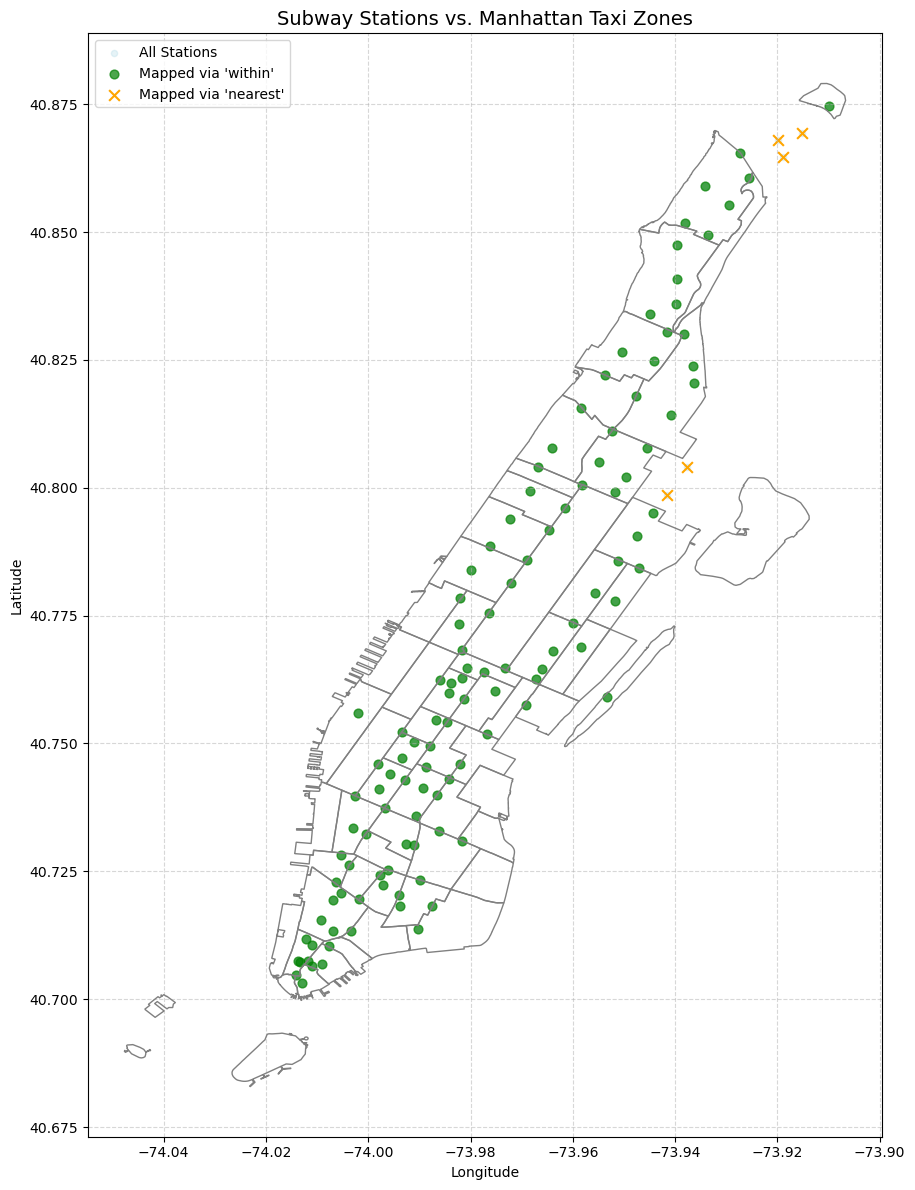

In [5]:
# 1. Reconstruct mapping subsets
within_ids = mapped["station_complex_id"].unique()
nearest_ids = final_mapping.loc[
    ~final_mapping["station_complex_id"].isin(within_ids), "station_complex_id"
].unique()

within_df = stations_df[stations_df["station_complex_id"].isin(within_ids)]
nearest_df = stations_df[stations_df["station_complex_id"].isin(nearest_ids)]

# 2. Build GeoDataFrames
within_gdf = gpd.GeoDataFrame(
    within_df,
    geometry=gpd.points_from_xy(within_df["longitude"], within_df["latitude"]),
    crs="EPSG:4326"
)

nearest_gdf = gpd.GeoDataFrame(
    nearest_df,
    geometry=gpd.points_from_xy(nearest_df["longitude"], nearest_df["latitude"]),
    crs="EPSG:4326"
)

# 3. Plot
fig, ax = plt.subplots(figsize=(12, 12))

# Manhattan zone outlines
zones_gdf.boundary.plot(ax=ax, color="gray", linewidth=1)

# Subway stations
stations_gdf.plot(ax=ax, color="lightblue", markersize=20, label="All Stations", alpha=0.3)
within_gdf.plot(ax=ax, color="green", markersize=40, label="Mapped via 'within'", alpha=0.7)
nearest_gdf.plot(ax=ax, color="orange", marker="x", markersize=60, label="Mapped via 'nearest'")

# Style
ax.set_title("Subway Stations vs. Manhattan Taxi Zones", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

### Summary

- Station-to-zone mapping completed using `within` and `nearest` strategies
- Saved output:
  - `station_to_zone_mapping.csv`
- Mapping validated visually to ensure geographic accuracy

This mapping can now be used to link subway records with Manhattan taxi zones for aggregation, zone-level features, and forecasting.
